# CAB420, Week 3 Practical - Question 1 - Template

## Binary Classification

Consider the data set redwine-binary.csv. This data contains both objective measurements on chemical and physical properties of the red wines, and subjective measurements of quality based on expert judegments. In this data, wine quality is the response variable and is either "above average" (1) or "below average" (0) Using this data set:

1. Fit a Support Vector Machine to the data, and select appropriate values of C and an appropriate kernel to maximise accuracy. 

2. Fit a K-Nearest Neighbours Classifier to the data, and select appropriate values of K and the distance metric to maximise accuracy.

For both models, repeat your experiments with and without standardising the data, and note any differences in performance. 

### Relevant Examples

The first classification example, ``CAB420_Classification_Example_1_Classification_Three_Ways.ipynb`` is a useful starting point here, as that also deals with binary classification.

You may also find ``CAB420_Classification_Additional_Example_Classifier_Parameters_and_Decision_Boundaries.ipynb`` useful if you are uncertain on what impacts hyper-parameters have on performance. Finally, if you want to explore different measures of performance, ``CAB420_Classification_Example_3_Classification_Metrics.ipynb`` will be worth a look.

### Suggested Packages

We're leaning on sklearn fairly heavily here. The following imports will give you all you need (and then some), and follow the lecture examples. You are obviously free to use other packages however.

In [1]:
# import important packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm

### Step 1: Data Loading and Splitting

Here you need to:
* Load the data, I'd suggest pandas and ``read_csv()`` as we've uesd elsewhere
* Pull out X and Y data. Your Y values are the ``quality`` data series
* Split the data into train and test. I'd suggest ``train_test_split`` from ``sklearn.model_selection``, which will split the data into two sets (i.e. split all data into train and test). If you wish to get three datasets (train, validation, and test), then:
  * Split the data into train and "the rest", using say a 70/30 split
  * Split "the rest" into validation and test, using a 50/50 split  

In [2]:
# load data
csv = pd.read_csv("redwine-binary.csv")
csv.head()


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


all
(1119, 12)
(240, 12)
(240, 12)
X,Y
(1119, 11)
(1119,)
(240, 11)
(240,)
(240, 11)
(240,)


(array([107., 133.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

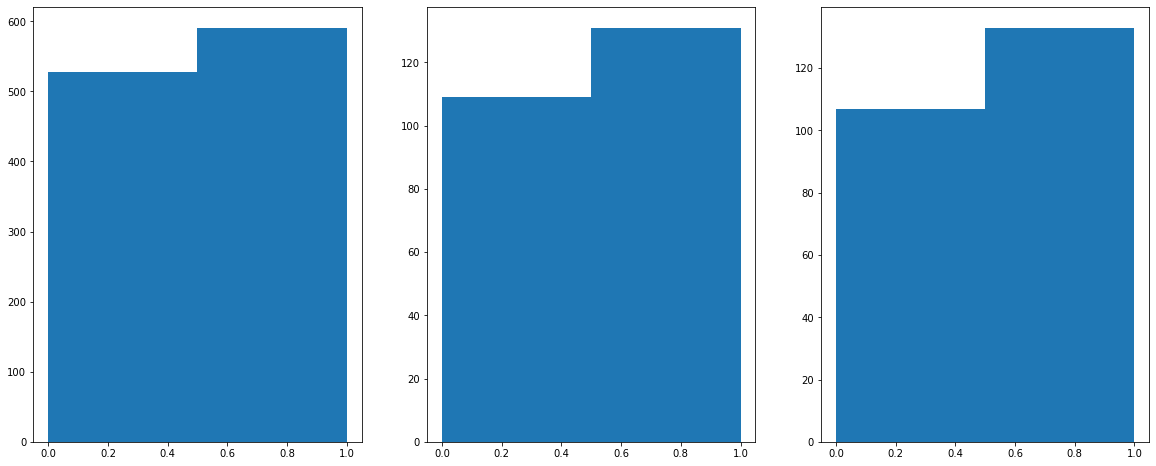

In [46]:
# split data into 3 sets
train, val_test = train_test_split(csv, train_size=0.7, test_size=0.3, random_state=41)
validation, test = train_test_split(val_test, train_size=0.5, random_state=41)

def split_x_y(data, y_column_name="quality"):
    X = data.loc[:, data.columns != y_column_name]
    Y = data[y_column_name]
    return X,Y

X_train,Y_train = split_x_y(train)
X_validation,Y_validation = split_x_y(validation)
X_test,Y_test = split_x_y(test)


print("all")

print(train.shape)
print(validation.shape)
print(test.shape)

print("===============")
print("X,Y")

print(X_train.shape)
print(Y_train.shape)

print(X_validation.shape)
print(Y_validation.shape)

print(X_test.shape)
print(Y_test.shape)

fig = plt.figure(figsize=[20,8])
axe = fig.add_subplot(1,3,1)
axe.hist(Y_train,2)

axe = fig.add_subplot(1,3,2)
axe.hist(Y_validation,2)

axe = fig.add_subplot(1,3,3)
axe.hist(Y_test,2)



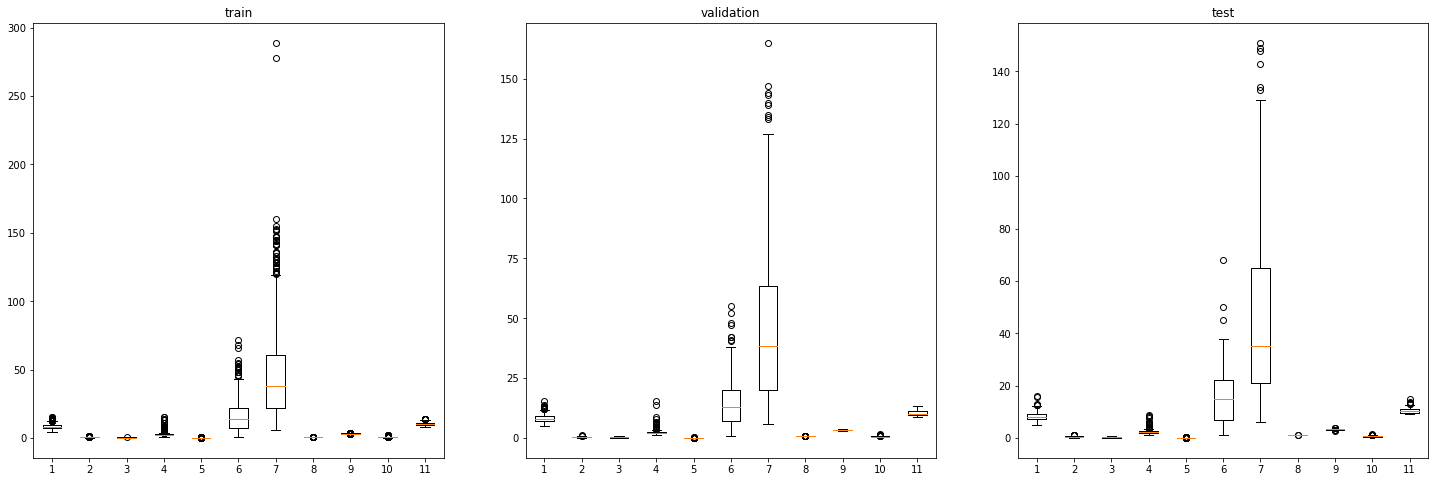

In [47]:
# draw box plots
def draw_box_plots(first, second, third):
    fig = plt.figure(figsize=[25,8])

    axe = fig.add_subplot(1,3,1)
    axe.set_title('train')
    axe.boxplot(first);

    axe = fig.add_subplot(1,3,2)
    axe.set_title('validation')
    axe.boxplot(second);

    axe = fig.add_subplot(1,3,3)
    axe.set_title('test')
    axe.boxplot(third);
draw_box_plots(X_train, X_validation,X_test)

### Step 1b: Standardisation

To standardise, or not to standardise?

Use a box plot to visualise the scale of the different dimensions in the X data. Focus on the training set. The question asks you to explore performance both with and without standardisation, which you can do simply by commenting out standardistaion code which could go about here.

Remember with your standardisation, you should compute the mean and standard deviation on the training set, and then use that mean and standard deviation to standardise your training, (validation? if you have it,) and testing sets.

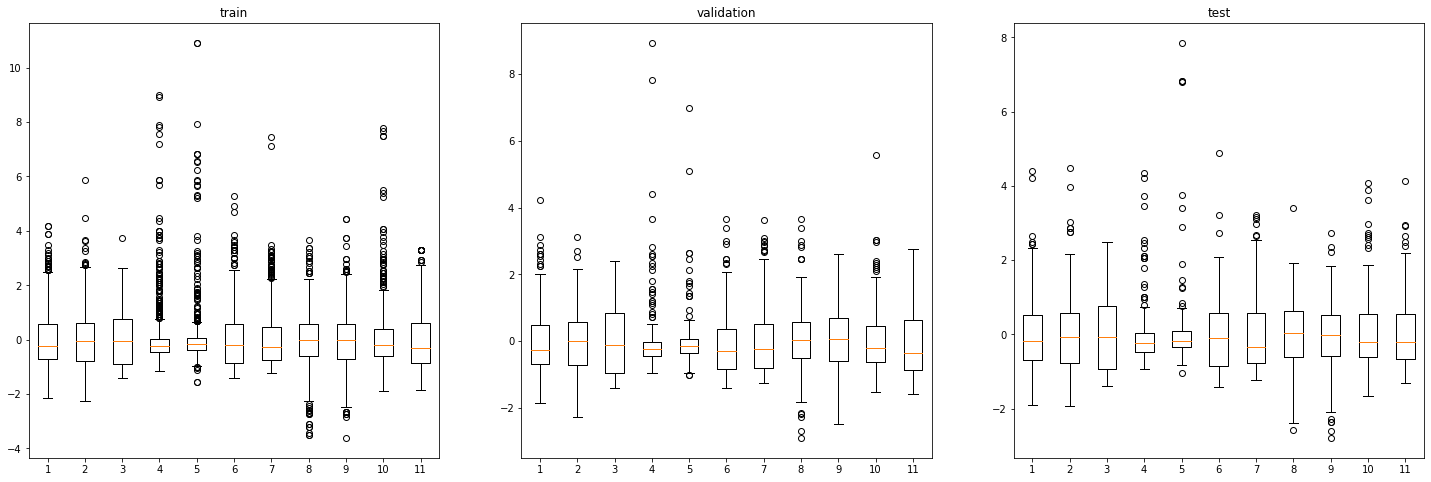

In [41]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler(with_mean=True, with_std=True).fit(X_train)

X_train = standard_scaler.transform(X_train)
X_validation = standard_scaler.transform(X_validation)
X_test = standard_scaler.transform(X_test)


draw_box_plots(X_train, X_validation,X_test)


### Step 2: Fitting Models

Here you need to:
* Fit an SVM, and explore parameter choices. In particular focus on what happens as you change C, the kernel, and kernel parameters ($\gamma$ with an RBF kernel, the polynomial order with a polynomial kernal). Parameter choices can be explored either by:
  * Simple trial and error
  * A grid search, or similar automated search method. Look at ``CAB420_Classification_Example_1_Classification_Three_Ways.ipynb`` for an example of how to use such methods. More information is also available in the [sklearn documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
* Fit a CKNN, once again exploring parameter choices. In particular focus on K, and the distance measure chosen. You may also wish to experiment with the distance weighting scheme used. Again, either trial and error or a grid search (or similar) is a good choice here.

An evaluation function is provided below, based on what is used in the lecture examples.

In [48]:
# helper function adapted from lecture examples

# function to do our eval for us, this is quite simple and will
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - get precision, recall, f1 for test data
# this has simply been created as we're going to do this for each test that we run
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    conf.ax_.set_title('Training Set Performance: %1.3f' % (sum(model.predict(X_train) == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    conf.ax_.set_title('Testing Set Performance: %1.3f' % (sum(model.predict(X_test) == Y_test)/len(Y_test)));
    print(classification_report(Y_test, model.predict(X_test)))

In [59]:
# my own Grid Search for SVM
import itertools
C = [ 1000,1200]
kernels = ['linear', 'rbf', 'poly']
combinations = itertools.product(C, kernels)

results = []
best_accuracy = 0
best_params = ()


for c, kernel in combinations:
    model = SVC(C=c, kernel=kernel).fit(X_train, Y_train)
    
    res = {}
    res["C"] = c
    res["kernel"] = kernel
    res["train accuracy"] = np.sum( model.predict(X_train) == Y_train) / len(Y_train)
    res["validation accuracy"] = np.sum( model.predict(X_validation) == Y_validation) / len(Y_validation)



    if (res["validation accuracy"] > best_accuracy):
        best_accuracy = res["validation accuracy"]
        best_params = (c, kernel)
    results.append(res)



{'C': 1000, 'kernel': 'linear', 'train accuracy': 0.7560321715817694, 'validation accuracy': 0.7125}
{'C': 1200, 'kernel': 'linear', 'train accuracy': 0.7596067917783735, 'validation accuracy': 0.7125}
{'C': 1200, 'kernel': 'poly', 'train accuracy': 0.7640750670241286, 'validation accuracy': 0.7125}
{'C': 1000, 'kernel': 'poly', 'train accuracy': 0.7649687220732797, 'validation accuracy': 0.7166666666666667}
{'C': 1000, 'kernel': 'rbf', 'train accuracy': 0.773011617515639, 'validation accuracy': 0.75}
{'C': 1200, 'kernel': 'rbf', 'train accuracy': 0.774798927613941, 'validation accuracy': 0.75}
best model:
accuracy: 0.75.  Params: (1000, 'rbf')


C
1000    AxesSubplot(0.125,0.125;0.775x0.755)
1200    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

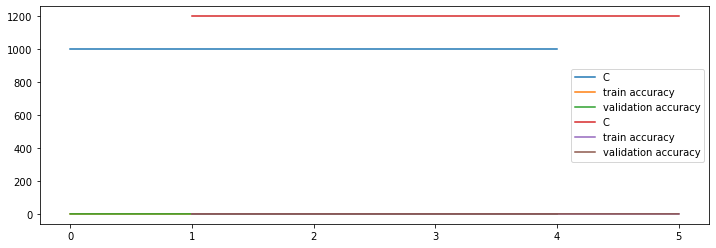

In [70]:
results.sort(key=lambda row: row["validation accuracy"])
for r in results:
    print(r)

print("best model:")
print(f"accuracy: {best_accuracy}.  Params: {best_params}")
df = pd.DataFrame(results)
fig = plt.figure(figsize=[12,4])
axe = fig.add_subplot(1,1,1)


In [53]:
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100, 1000], 'degree': [3, 4, 5, 6], 'kernel': ['poly']},
 ]
svm = SVC()
grid_search = GridSearchCV(svm, param_grid)
grid_search.fit(X_train, Y_train)
grid_search.cv_results_

{'mean_fit_time': array([1.02284336e-01, 7.23565435e-01, 5.63136978e+00, 3.96147137e+01,
        8.29941563e+01, 4.29746628e-02, 3.81849289e-02, 4.12205219e-02,
        3.94872189e-02, 5.14207840e-02, 4.38446999e-02, 3.25709343e-02,
        3.82102489e-02, 6.11990452e-02, 3.47344875e-02, 4.25961971e-02,
        4.29311275e-02, 6.32289886e-02, 6.86750412e-02, 5.46858788e-02,
        3.89487267e-02, 6.57546043e-02, 3.25045156e-01, 1.37014246e-01,
        6.49336338e-02, 3.27990055e-02, 5.04570007e-02, 4.51770306e-02,
        7.02232361e-02, 3.58937740e-02, 5.81648827e-02, 7.66808033e-02,
        1.53169870e-01, 6.13928318e-02, 1.02187443e-01, 1.95606709e-01,
        6.09583998e-01, 1.29061127e-01, 4.29222107e-01, 1.35653687e+00,
        7.95882025e+00, 2.40642800e+00, 9.58389812e+00, 2.27225983e+01,
        6.45811623e+01]),
 'std_fit_time': array([2.98369592e-02, 1.01299415e-01, 2.18109557e+00, 7.20764138e+00,
        2.35689581e+01, 9.25352561e-03, 1.13229176e-02, 7.95763321e-03,
     